In [213]:
#PARAMETERS
testDataFile="/Users/eliotpbrenner/PycharmProjects/SparsityBoost/data/synthetic_examples/experiments/0/alarm1000.dat"
numTestVariable=37
numTestDataPts=1000
studentJSONFile = "student.txt"
studentDataFile="student_100kSamples.csv"
studentNValsFile="student_nvals.csv"
numStudentVariable=5
numStudentDataPts=100000

100000

In [216]:
# Imports
using Base.Test
using Iterators

In [217]:
type model
  nodes::Int64
  nval::Array{Int64,1}
  dataArray::Array{Int64,2}
end

In [218]:
type jointDistWithMarginals
  pdist::Array{Float64,2}
  p_A::Array{Float64,1}
  p_B::Array{Float64,1}
end

In [219]:
# Constructor which calculates the marginals
jointDistWithMarginals(pdist::Array{Float64,2}) = jointDistWithMarginals(pdist, vec(sum(pdist,2)), vec(sum(pdist,1)))

jointDistWithMarginals

In [220]:
jointDistWithMarginals([[0.25 0.25]; [ 0.25 0.25]])

jointDistWithMarginals(2x2 Array{Float64,2}:
 0.25  0.25
 0.25  0.25,[0.5,0.5],[0.5,0.5])

In [221]:
jointDistWithMarginals([[0.25 0.125 0.125]; [ 0.25 0.125 0.125]])

jointDistWithMarginals(2x3 Array{Float64,2}:
 0.25  0.125  0.125
 0.25  0.125  0.125,[0.5,0.5],[0.5,0.25,0.25])

In [222]:
function readDataBinary(filePath::AbstractString)
  dataArray = readdlm(filePath, ' ', Int);
  nodes=size(dataArray)[2];
  nval=2*ones(Int, nodes)
  theModel = model(nodes,nval,dataArray);
end


readDataBinary (generic function with 1 method)

In [223]:
function readData(dataFilePath::AbstractString, nvalsFilePath::AbstractString)
  dataArray = readdlm(dataFilePath, ',', Int);
  nodes=size(dataArray)[2];
    nval=vec(readdlm(nvalsFilePath, ',', Int));   #2*ones(Int, nodes)
  theModel = model(nodes,nval,dataArray);
end

readData (generic function with 1 method)

In [196]:
m=readData(studentDataFile, studentNValsFile)

model(5,[2,2,3,2,2],100000x5 Array{Int64,2}:
 0  0  1  0  0
 0  0  0  1  1
 1  0  2  0  0
 0  0  2  0  0
 1  1  0  1  1
 0  0  1  0  0
 0  0  2  0  0
 0  0  0  0  1
 0  0  1  0  1
 0  0  1  0  0
 0  0  1  0  0
 0  1  0  1  1
 0  0  0  0  1
 ⋮            
 0  0  1  0  0
 1  1  2  1  0
 0  0  1  0  1
 0  0  0  0  1
 0  0  2  0  0
 0  0  1  0  0
 0  1  0  0  1
 1  1  1  1  0
 0  1  0  0  0
 1  0  1  1  0
 1  1  0  1  1
 0  0  2  0  0)

In [224]:
# test readData function
m=readData(studentDataFile, studentNValsFile)
@test size(m.dataArray) == (numStudentDataPts, numStudentVariable)

In [225]:
function verify(aJointDistributionWithMarginals::jointDistWithMarginals)
  sumA=sum(aJointDistributionWithMarginals.pdist,2)
  sumB=sum(aJointDistributionWithMarginals.pdist,1)
  @test_approx_eq(transpose(sumA),aJointDistributionWithMarginals.p_A)
  @test_approx_eq(sumB,aJointDistributionWithMarginals.p_B)
  @test_approx_eq(sum(sumA),1.0)
  return true
end

verify (generic function with 1 method)

In [226]:
goodDist=jointDistWithMarginals([[0.25 0.25]; [ 0.25 0.25]], [0.5; 0.5], [0.5; 0.5])
@test verify(goodDist) == true

In [227]:
#TODO: determine why this this test fails instead of succeeding!
badDist = jointDistWithMarginals([[0.25 0.25]; [ 0.25 0.25]], [0.6; 0.4], [0.5; 0.5])
@test_throws( ErrorException, verify(badDist))

ErrorException("assertion failed: |transpose(sumA) - aJointDistributionWithMarginals.p_A| <= 2.220446049250313e-12\n  transpose(sumA) = [0.5 0.5]\n  aJointDistributionWithMarginals.p_A = [0.6,0.4]\n  difference = 0.09999999999999998 > 2.220446049250313e-12")

In [228]:
function MI_term(i::Int, j::Int, dist::jointDistWithMarginals)
  return dist.pdist[i,j]*log(dist.pdist[i,j]/(dist.p_A[i]*dist.p_B[j])  )
end

MI_term (generic function with 1 method)

In [269]:
function MI(dist::jointDistWithMarginals)
  (a,b)=size(dist.pdist)
  return sum([(MI_term(i,j,dist)) for i=1:a, j=1:b])
end

MI (generic function with 3 methods)

In [230]:
function MI(m::model,i::Int,j::Int,SToVal::Dict)
  """
  TODO: test
  """
  MI(conditionalDist(m::model,i::Int,j::Int,SToVal::Dict))
end

MI (generic function with 3 methods)

In [212]:
MI(m,1,3,Dict(2=>1, 4=>1))

LoadError: LoadError: lengths of transpose(sumA) and aJointDistributionWithMarginals.p_A do not match: 
  transpose(sumA) (length 3) = [0.7418091468036722
 0.16798618714730904
 0.09020466604901879]
  aJointDistributionWithMarginals.p_A (length 2) = [0.6002695190768971,0.3997304809231028]
while loading In[212], in expression starting on line 1

In [205]:
MI_term(1,1,goodDist)

0.0

In [34]:
@test_approx_eq(MI(goodDist),0)

In [35]:
t=0.01
anotherDist=jointDistWithMarginals([[0.25+t 0.25-t]; [ 0.25-t 0.25+t]], [0.5; 0.5], [0.5; 0.5])
verify(anotherDist)
@test_approx_eq(MI(anotherDist), 0.0008002134699838133)

In [36]:
testNotInDict(elt::Int, SToVal::Dict) = try
    """TODO: figure out how to propagate y up the call stack if it's not a KeyError"""
    x=SToVal[elt] 
    warn("$elt is in $SToVal with value $x")
    throw(DomainError())
  catch y
    if isa(y, KeyError)
      return true
    else
      return y
    end
  end

testNotInDict (generic function with 1 method)

In [37]:
S=Dict(1=>2, 3=>4)

Dict{Int64,Int64} with 2 entries:
  3 => 4
  1 => 2

In [38]:
testNotInDict(1,S)

DomainError()

In [231]:
function conditionalDist(m::model,i::Int,j::Int,SToVal::Dict)
  """
  TODO: that S is a dict of integers and that both are valid for the model
  TODO: vectorize the computation of the pDist
  """
  @test i!=j
  @test testNotInDict(i, SToVal) == true
  @test testNotInDict(j, SToVal) ==true
  selectedPoints = m.dataArray[reduce(&,[m.dataArray[:,condVar] .==SToVal[condVar] for condVar in keys(SToVal)]),:]
  numSelectedPoints = size(selectedPoints)[1]
  pDist = zeros(m.nval[i], m.nval[j])
  for k = 1:m.nval[i]
      for l = 1:m.nval[j]
          pDist[k,l] = size(selectedPoints[(selectedPoints[:,i] .==k-1)&(selectedPoints[:,j] .==l-1), :])[1]/numSelectedPoints
    end
  end
    jd = jointDistWithMarginals(pDist)
    #verify(jd)
    return jd
end

conditionalDist (generic function with 1 method)

In [232]:
SToVal = Dict(2=>0, 4=>1)
cd = conditionalDist(m, 1, 3, SToVal)

jointDistWithMarginals(2x3 Array{Float64,2}:
 0.18229    0.241131  0.183444
 0.0227863  0.09576   0.274589,[0.6068647245457167,0.39313527545428323],[0.2050764349581771,0.3368906835881165,0.45803288145370635])

In [233]:
@test_throws(ErrorException,conditionalDist(m, 1, 1, SToVal))

ErrorException("test failed: 1 != 1\n in expression: i != j")

In [234]:
conditionalDist(m, 3, 1, SToVal)

jointDistWithMarginals(3x2 Array{Float64,2}:
 0.18229   0.0227863
 0.241131  0.09576  
 0.183444  0.274589 ,[0.2050764349581771,0.3368906835881165,0.45803288145370635],[0.6068647245457167,0.39313527545428323])

In [235]:
#TODO: determine why this test is failing
@test_throws(DomainError, conditionalDist(m, 3, 1, S))

LoadError: LoadError: test failed: ErrorException("test failed: DomainError() == true\n in expression: testNotInDict(i,SToVal) == true") was thrown instead of DomainError
 in expression: conditionalDist(m,3,1,S)
while loading In[235], in expression starting on line 2

In [236]:
conditionalDist(m, 3, 1, S)

LoadError: LoadError: test failed: DomainError() == true
 in expression: testNotInDict(i,SToVal) == true
while loading In[236], in expression starting on line 1

In [237]:
function MI(m::model, i::Int, j::Int, S::Array{Int64,1})
  """
  TODO: test
  """
  max=-Inf
  for p in Iterators.product([1:m.nval[k]-1 for k in S]...)
        candidate=MI(m,i,j, Dict(zip(S,p)))
    if candidate > max
      max=candidate
    end
  end
  return max
end

MI (generic function with 3 methods)

In [272]:
function epsilon(m::model, i::Int, j::Int, d::Int)
    min=Inf
    bestK=Array([])
    for di in (1:d)
        for k in combinations(1:m.nodes,di)
            if (i in k) || (j in k)
                continue
            end
            candidate = MI(m,i,j,k)
            if candidate < min
                min=candidate
                bestK=k
            end
        end
    end
    return bestK, min
end

epsilon (generic function with 2 methods)

In [270]:
epsilon(m,1,2,1)

22

([4],1.0097662376677198e-5)

[0.5899072125832154 0.04856679659204581
 0.24014349280811287 0.12138249801662584]22[0.36414959163203897 0.010259349477002435
 0.559335148302049 0.06625591058890959]22[0.07731598868187999 0.5237937750339912
 0.05008635578583765 0.34880388049829125]22[0.43130112856033914 0.3037758006409108
 0.1146274954718258 0.15029557532692422]

In [240]:
using PyCall


In [241]:
@pyimport graphviz

In [242]:
ndModule = pyimport("libpgm.nodedata")

PyObject <module 'libpgm.nodedata' from '/Users/eliotpbrenner/anaconda/lib/python2.7/site-packages/libpgm/nodedata.pyc'>

In [243]:
ndObj=pycall(ndModule["NodeData"], PyCall.PyObject)

PyObject <libpgm.nodedata.NodeData object at 0x319067ed0>

In [244]:
pycall(ndObj["load"],PyCall.PyObject, studentJSONFile)

PyObject None

In [245]:
gsModule = pyimport("libpgm.graphskeleton")

PyObject <module 'libpgm.graphskeleton' from '/Users/eliotpbrenner/anaconda/lib/python2.7/site-packages/libpgm/graphskeleton.pyc'>

In [246]:
gsObj=pycall(gsModule["GraphSkeleton"], PyCall.PyObject)

PyObject <libpgm.graphskeleton.GraphSkeleton object at 0x319067f90>

In [247]:
pycall(gsObj["load"], PyCall.PyAny, studentJSONFile )

dbnModule = pyimport("libpgm.discretebayesnetwork")
dbnObj = pycall(dbnModule["discretebayesiannetwork"], PyCall.PyAny)
adbn = pycall(dbnObj["DiscreteBayesianNetwork"], PyCall.PyObject, skel, ndb)

In [248]:
dbnModule = pyimport("libpgm.discretebayesiannetwork")


PyObject <module 'libpgm.discretebayesiannetwork' from '/Users/eliotpbrenner/anaconda/lib/python2.7/site-packages/libpgm/discretebayesiannetwork.pyc'>

In [249]:
dbnObj = pycall(dbnModule["DiscreteBayesianNetwork"], PyCall.PyAny, gsObj, ndObj)


PyObject <libpgm.discretebayesiannetwork.DiscreteBayesianNetwork object at 0x319067a10>

In [250]:
V = pycall(dbnObj["__getattribute__"], Array, "V")

5-element Array{Any,1}:
 "Difficulty"  
 "Intelligence"
 "Grade"       
 "SAT"         
 "Letter"      

In [251]:
E = pycall(dbnObj["__getattribute__"], Array, "E")

4x2 Array{Any,2}:
 "Intelligence"  "Grade" 
 "Difficulty"    "Grade" 
 "Intelligence"  "SAT"   
 "Grade"         "Letter"

In [252]:
g = graphviz.Graph(format="svg")

In [253]:
pycall(g["node"], PyCall.PyObject, "Difficulty")
pycall(g["node"], PyCall.PyObject, "Grade")
pycall(g["edge"], PyCall.PyObject, "Difficulty", "Grade")

PyObject None

In [254]:
print(pycall(g["__getattribute__"], ASCIIString, "source"))

graph {
	Difficulty
	Grade
		Difficulty -- Grade
}

In [255]:
vertexEncodings = [v=>i for (i,v) in enumerate(V)]

Dict{Any,Int64} with 5 entries:
  "Intelligence" => 2
  "Difficulty"   => 1
  "SAT"          => 4
  "Grade"        => 3
  "Letter"       => 5

In [256]:
E

4x2 Array{Any,2}:
 "Intelligence"  "Grade" 
 "Difficulty"    "Grade" 
 "Intelligence"  "SAT"   
 "Grade"         "Letter"

In [257]:
edgesEncoded = [[vertexEncodings[E[i,1]],vertexEncodings[E[i,2]]] for i in 1:size(E)[1]]

4-element Array{Any,1}:
 [2,3]
 [1,3]
 [2,4]
 [3,5]

In [258]:
dg = graphviz.Digraph()

In [259]:
for (v,i) in vertexEncodings
    pycall(dg["node"], PyCall.PyObject, string(uppercase(Char(i+96))), v)
end

In [260]:
for rownum in 1:size(edgesEncoded)[1]
    string(uppercase(Char(edgesEncoded[rownum][1]+96)))*string(uppercase(Char(edgesEncoded[rownum][2]+96))) #*string(uppercase(Char(edgesEncoded[rownum][2]+96)))
    pycall(dg["edges"], PyCall.PyObject, [string(uppercase(Char(edgesEncoded[rownum][1]+96)))*string(uppercase(Char(edgesEncoded[rownum][2]+96)))])
end

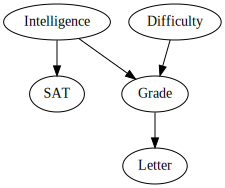

In [261]:
dg

In [268]:
epsilon(bn, "SAT", "Grade", 2)

23

([2,5],3.9410283949802694e-5)

[0.06459408432976715 0.18308370044052863 0.47906859660163625
 0.12203901825047199 0.08075519194461926 0.07045940843297671]23[0.14887583552764838 0.03166565390588076 0.01782458983188171
 0.5946593747890082 0.13466342583215177 0.0723111201134292]23[0.3191417368284867 0.2838319300969328 0.0059712187257419235
 0.32883501522660774 0.06140403256304612 0.0008160665591847296]23[0.10344244269643914 0.05438551974964053 0.0393301192590713
 0.40336631988496996 0.2432546730948152 0.15622092531506385]23[0.1743801652892562 0.33478587528174303 0.012997746055597295
 0.32922614575507136 0.1464312546957175 0.0021788129226145755]23[0.17323455924253714 0.0245474071801166 0.0003068425897514575
 0.6961381668346995 0.10480866172796213 0.0009643624249331521]

In [263]:
type ModelWithBN
    m::model
    vertexEncodings::Dict{ASCIIString,Int64}
    edgesEncoded::Array{Array{Int64,1},1}
end

In [273]:
function epsilon(BN::ModelWithBN, node_i::ASCIIString, node_j::ASCIIString, d::Int)
    epsilon(BN.m, BN.vertexEncodings[node_i], BN.vertexEncodings[node_j],d)
end

epsilon (generic function with 2 methods)

In [265]:
bn = ModelWithBN(m,vertexEncodings, edgesEncoded)

ModelWithBN(model(5,[2,2,3,2,2],100000x5 Array{Int64,2}:
 0  0  1  0  0
 0  0  0  1  1
 1  0  2  0  0
 0  0  2  0  0
 1  1  0  1  1
 0  0  1  0  0
 0  0  2  0  0
 0  0  0  0  1
 0  0  1  0  1
 0  0  1  0  0
 0  0  1  0  0
 0  1  0  1  1
 0  0  0  0  1
 ⋮            
 0  0  1  0  0
 1  1  2  1  0
 0  0  1  0  1
 0  0  0  0  1
 0  0  2  0  0
 0  0  1  0  0
 0  1  0  0  1
 1  1  1  1  0
 0  1  0  0  0
 1  0  1  1  0
 1  1  0  1  1
 0  0  2  0  0),Dict("Intelligence"=>2,"Difficulty"=>1,"SAT"=>4,"Grade"=>3,"Letter"=>5),[[2,3],[1,3],[2,4],[3,5]])

In [286]:
function computeEpsilonArray(BN::ModelWithBN, d::Int)
    for i in 1:1 #length(BN.edgesEncoded)
        return [epsilon(BN.m,BN.edgesEncoded[i][1], BN.edgesEncoded[i][2],d ) for i in 1:length(BN.edgesEncoded)]
    end
end

computeEpsilonArray (generic function with 1 method)

In [289]:
a=computeEpsilonArray(bn,2)

23[0.0357960981749528 0.175254877281309 0.4913278791692889
 0.15083700440528636 0.0885840151038389 0.0582001258653241]23[0.02612721860875317 0.04292066291845809 0.05835446294050638
 0.6473009223532871 0.14658435306654907 0.07871238011244626]23[0.25321948209629586 0.2864990744610975 0.006210067474771601
 0.3947572699587986 0.05873688819888139 0.0005772178101550526]23[0.007277752187931828 0.030584983878397053 0.08770152003684938
 0.4393367111929986 0.2649470290188853 0.17015200368493782]23[0.09827197595792637 0.32096168294515404 0.013448534936138241
 0.4053343350864012 0.16025544703230654 0.0017280240420736287]23[0.032574947829185116 0.03532345905227261 0.0009670687636789332
 0.8083167913676388 0.12169796915559628 0.0011197638316282385]23[0.5412531226790899 0.047532239551684556 0.012085612045101614
 0.20228208763756667 0.11879684018634798 0.07805009790020931]23[0.4952779921361114 0.07162018153088598 0.0342115900488737
 0.17815014882592878 0.11788483445412119 0.10285525300407894]23[0.5145

4-element Array{Tuple{Union{Array{Any,1},Array{Int64,1}},Float64},1}:
 ([4,5],0.027708964861958035)
 ([5],0.016717629711182107)  
 ([3],0.22425733287320757)   
 ([2],0.1807663791582597)    

[0.8779767875053732 0.045507952428714714
 0.015131107608539906 0.06138415245737212]22[0.5189984275790689 0.026930196453096078
 0.08994645807209252 0.36412491789574253]22[0.6325732277454441 0.031676366758897054
 0.061349107909550615 0.2744012975861082]22[0.8504809894640403 0.043609711406321576
 0.02130096197892808 0.08460833715071003]22[0.41111945905334335 0.02156273478587528
 0.1110443275732532 0.45627347858752815]22[0.7898529835687518 0.04001153070049005
 0.03228596137215336 0.13784952435860479]22[0.8592375366568915 0.05571847507331378
 0.020527859237536656 0.06451612903225806]32[0.0178980490874764 0.16873505349276274
 0.10260541220893644 0.16123348017621145
 0.5444430459408433 0.0050849590937696665]32[0.07399905475659982 0.6695361555600567
 0.06670717709810275 0.09962190263992979
 0.08915670785227196 0.0009790020930389575]32[0.066328592951898 0.6070995480101422
 0.07614008010877155 0.11336493587623563
 0.13556021019365744 0.0015066328592951898]32[0.050494798274549606 0.45631396430685

In [284]:
epsilonArray[1]

0.0

In [290]:
a

4-element Array{Tuple{Union{Array{Any,1},Array{Int64,1}},Float64},1}:
 ([4,5],0.027708964861958035)
 ([5],0.016717629711182107)  
 ([3],0.22425733287320757)   
 ([2],0.1807663791582597)    